In [1]:
%matplotlib inline
import numpy as np
     
from netCDF4 import Dataset # http://unidata.github.io/netcdf4-python/
import xarray as xr
#import Nio
import os

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap,shiftgrid,addcyclic, cm 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [2]:
# reading in the desirable chunk of data

iniyr  = 1948
endyr  = 2016
nyr    = endyr - iniyr +1

inindx = 12*(iniyr-1948)
endndx = 12*(endyr-1948+1)

ncfile = '/data/obs_data/NOAA_2mTemp/air.mon.mean.nc'

f = xr.open_dataset(ncfile)
f = f.assign_coords(lon=((f.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
airt =  f.air[inindx:endndx,::-1,:]
lon  =  f.lon
lat  =  f.lat[::-1] 
lon  =  f.lon
time = f.time[inindx:endndx]

airt = airt - 273.15
airt.attrs['units'] = 'degCelcius'

In [3]:
# cropping the US domain
US = [ 25 , 55 , -130 , -60 ] # [minlat , maxlat, minlon, maxlon] 

airt_US  =  airt.sel(lat=slice(US[0],US[1]),lon=slice(US[2],US[3])).squeeze()
lons_US, lats_US = np.meshgrid(airt_US.lon,airt_US.lat)

In [4]:
import pandas as pd
def xr_reshape(A, dim, newdims, coords): # written by dimitryx2017: https://github.com/pydata/xarray/issues/2419
    """ Example: Ar = xr_reshape(A, 'time', ['year', 'month'], [(2017, 2018), np.arange(12)]) """

    # Create a pandas MultiIndex from these labels
    ind = pd.MultiIndex.from_product(coords, names=newdims)

    # Replace the time index in the DataArray by this new index,
    A1 = A.copy()
    A1.coords[dim] = ind

    # Convert multiindex to individual dims using unstack(). This changes dimension order! The new dimensions are at the end.
    A1 = A1.unstack(dim)

    # Permute to restore dimensions
    i = A.dims.index(dim)
    dims = list(A1.dims)

    for d in newdims[::-1]:
        dims.insert(i, d)

    for d in newdims:
        _ = dims.pop(-1)

    return A1.transpose(*dims)

# calculating monthly climatologies
ntime,nlat,nlon = airt_US.shape
airt_US_mon = xr_reshape(airt_US, 'time', ['year', 'month'], [np.arange(iniyr,endyr+1), np.arange(12)])
airt_US_clm = airt_US_mon.mean(axis=0) # along the year axis
airt_US_clm.shape

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(12, 60, 140)

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,'air temperature Climatology 1948-2017')

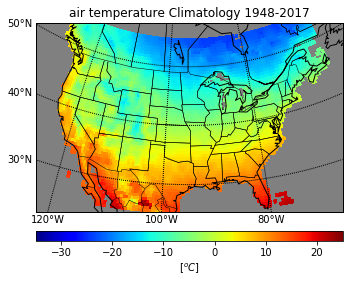

In [5]:
m = Basemap(projection='stere', resolution='c', llcrnrlat=22,urcrnrlat=50,llcrnrlon=-122,urcrnrlon=-53,lat_0=45, lon_0=-95)
#m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='gray')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawparallels(np.arange(30.,60.,10.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-120.,-60.,20.), labels=[0,0,0,1])

h = m.pcolormesh(lons_US, lats_US, airt_US_clm[0,:,:], shading='flat',latlon=True, cmap='jet', vmin=-35.0, vmax=25.0)
m.colorbar(h, location='bottom', pad="10%", label='[$^oC$]')

plt.title('air temperature Climatology 1948-2017')